In [ ]:
#importing necessary libraries
import pandas as pd

In [ ]:
# reading the text file
email_data = pd.read_csv('email.txt', sep='\t', names=['temp', 'email_body'])

In [ ]:
email_data.head()

,temp,email_body
0,No,I look forward to meeting you and learning abo...
1,No,We look forward to seeing you next week!
2,No,A quick question before our meeting.
3,No,After sunning and drinking all day we feasted ...
4,No,"Also Tuesday, Kyle and Eric 1/2 hour."


In [ ]:
email_data.drop('temp', axis = 1, inplace = True)

In [ ]:
# importing the transfomers
from transformers import pipeline

# importing the transformer
sentiment_analyzer = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment", framework = 'pt')

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [ ]:
#labelling the target
email_data['sentiment'] = email_data['email_body'].apply(lambda x: sentiment_analyzer(x)[0]['label'])

In [ ]:
email_data.head()

,email_body,sentiment
0,I look forward to meeting you and learning abo...,LABEL_2
1,We look forward to seeing you next week!,LABEL_2
2,A quick question before our meeting.,LABEL_1
3,After sunning and drinking all day we feasted ...,LABEL_2
4,"Also Tuesday, Kyle and Eric 1/2 hour.",LABEL_1


In [ ]:
#mapping the labels to the target
labels = {"LABEL_0": 'negative', "LABEL_1": 'neutral', "LABEL_2": 'positive'}
email_data['sentiment'] = email_data['sentiment'].map(labels)

In [ ]:
email_data.head()

,email_body,sentiment
0,I look forward to meeting you and learning abo...,positive
1,We look forward to seeing you next week!,positive
2,A quick question before our meeting.,neutral
3,After sunning and drinking all day we feasted ...,positive
4,"Also Tuesday, Kyle and Eric 1/2 hour.",neutral


In [ ]:
# Importing the Groq library, which seems to be used for interacting with a language model.
from groq import Groq

# Function to detect the formality of a given text.
def detect_formality(text):
    # API key for authentication with the Groq client.
    api_key = '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'
    
    # Initializing the Groq client with the provided API key.
    client = Groq(api_key=api_key)
    
    # Creating a chat completion request using the specified model and settings.
    completion = client.chat.completions.create(
        model="llama-3.1-70b-versatile",  # Using the 'llama-3.1-70b-versatile' model.
        messages=[
            # User message prompts the model to evaluate the formality of the provided text.
            {
                "role": "user",
                "content": f"tell if this text is formal or not in one word '{text}'"
            },
            # Assistant role placeholder for the model's response.
            {
                "role": "assistant",
            }
        ],
        temperature=0.2,  # Low temperature for more deterministic responses.
        max_tokens=100,  # Limit on the number of tokens in the output.
        top_p=1,  # Controls the nucleus sampling for output generation.
        stream=True,  # Enable streaming of responses for real-time processing.
        stop=None,  # No explicit stopping condition defined.
    )
    
    # Initializing an empty string to accumulate the response.
    res = ""
    
    # Iterating over the streaming response chunks from the completion.
    for chunk in completion:
        # Extracting and appending the content of each chunk to the result string.
        res += chunk.choices[0].delta.content or ""
    
    # Returning the accumulated result as the final response.
    return res

In [ ]:
# getting the formal level of a mail
email_data['formality'] = email_data['email_body'].apply(detect_formality)

In [ ]:
email_data.head()

,email_body,sentiment,formality
0,I look forward to meeting you and learning abo...,positive,Formal.
1,We look forward to seeing you next week!,positive,Formal
2,A quick question before our meeting.,neutral,Informal.
3,After sunning and drinking all day we feasted ...,positive,Informal.
4,"Also Tuesday, Kyle and Eric 1/2 hour.",neutral,Informal


In [ ]:
#viewing the count
email_data.formality.value_counts()

formality
Informal     371
Formal.      281
Informal.    231
Formal       109
Name: count, dtype: int64

In [ ]:
# handling the inconsistancies in formality
email_data['formality'].replace(['Formal.', 'Formal'], 'formal', inplace = True)
email_data['formality'].replace(['Informal.', 'Informal'], 'informal', inplace = True)


In [ ]:
#viewing the count
email_data.formality.value_counts()

formality
informal    602
formal      390
Name: count, dtype: int64

In [ ]:
#saving the data into to csv file
email_data.to_csv('email_data_labels.csv')

In [ ]:
#reading the data
fine_tune_data = pd.read_csv('email_data_labels_after_correction.csv')

In [ ]:
#combining labels to create a single label
fine_tune_data['output'] = fine_tune_data['sentiment']+" "+fine_tune_data['formality']

In [ ]:
#data cleaning
fine_tune_data.drop(['Unnamed: 0', 'sentiment', 'formality'], axis=1,inplace=True)

In [ ]:
#renaming the columns
fine_tune_data = fine_tune_data.rename(columns={'email_body':'input'})

In [ ]:
fine_tune_data.head()

,input,output
0,I look forward to meeting you and learning abo...,positive formal
1,We look forward to seeing you next week!,positive formal
2,A quick question before our meeting.,neutral informal
3,After sunning and drinking all day we feasted ...,positive informal
4,"Also Tuesday, Kyle and Eric 1/2 hour.",neutral informal


In [ ]:
#saving the changes to a csv file
fine_tune_data.to_csv('fine_tune_data.csv')

## Visualizations

In [4]:
email_data = pd.read_csv('email_data_labels.csv', index_col='Unnamed: 0')

In [5]:
email_data.head() #Before making the wordcloud. we need to do some preprocessing on the text

,email_body,sentiment,formality
0,I look forward to meeting you and learning abo...,positive,formal
1,We look forward to seeing you next week!,positive,formal
2,A quick question before our meeting.,neutral,informal
3,After sunning and drinking all day we feasted ...,positive,informal
4,"Also Tuesday, Kyle and Eric 1/2 hour.",neutral,informal


In [12]:
# Import required libraries
# Preprocessing Function (Define or Import this)
import string
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [68]:
def preprocess_text(text):
    # Define custom stop words
    custom_stop_words = {"week", "day", "meetings", "meeting", "weekend","weeks",
                         "discuss", "monday","tuesday", "wednesday", "thursday",
                         "friday", "saturday","sunday", "next", "morning", "night",
                         "time", "tomorrow", "enron", "issue", "issues"} #removing some common words that are found in mails
                         #enron is the name of the email dataset, so it is repeated in the emails multiple times

    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Combine default and custom stop words
    stop_words = set(stopwords.words('english')).union(custom_stop_words)
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into a single string
    return " ".join(tokens)

In [ ]:
# Getting the data with specific labels
email_data_pos = email_data.loc[email_data['sentiment'] == 'positive']
email_data_neg = email_data.loc[email_data['sentiment'] == 'negative']
email_data_neu = email_data.loc[email_data['sentiment'] == 'neutral']

email_data_formal = email_data.loc[email_data['formality'] == 'formal']
email_data_informal = email_data.loc[email_data['formality'] == 'informal']


In [ ]:
# Veiwing the size 
print("Size of positive email dataset",email_data_pos.shape)
print("Size of negative email dataset",email_data_neg.shape)
print("Size of neutral email dataset",email_data_neu.shape)
print("Size of formal email dataset",email_data_formal.shape)
print("Size of informal email dataset",email_data_informal.shape)

Size of positive email dataset (176, 3)
Size of negative email dataset (90, 3)
Size of neutral email dataset (726, 3)
Size of formal email dataset (390, 3)
Size of informal email dataset (602, 3)


<ipython-input-71-d1509ba51527>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  email_data_pos['preprocessed_text'] = email_data_pos['email_body'].apply(preprocess_text)


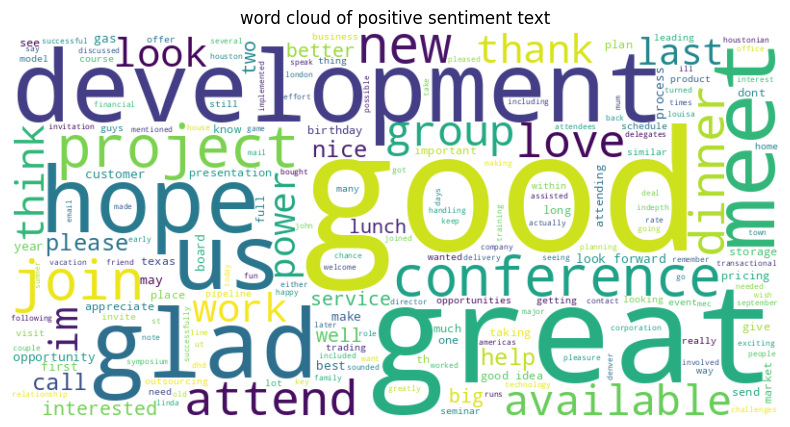

In [71]:
email_data_pos['preprocessed_text'] = email_data_pos['email_body'].apply(preprocess_text)

# Combine all preprocessed text into a single string
pos_text = " ".join(email_data_pos['preprocessed_text'])

# Generate the Word Cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate(pos_text)

# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("word cloud of positive sentiment text")
plt.show()

<ipython-input-72-6a32949535c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  email_data_neg['preprocessed_text'] = email_data_neg['email_body'].apply(preprocess_text)


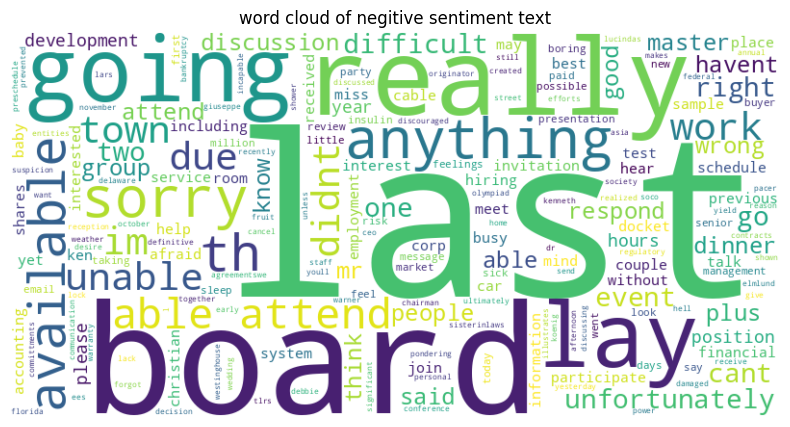

In [72]:
email_data_neg['preprocessed_text'] = email_data_neg['email_body'].apply(preprocess_text)

# Combine all preprocessed text into a single string
neg_text = " ".join(email_data_neg['preprocessed_text'])

# Generate the Word Cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate(neg_text)

# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("word cloud of negitive sentiment text")
plt.show()

<ipython-input-73-8574e10b1e90>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  email_data_neu['preprocessed_text'] = email_data_neu['email_body'].apply(preprocess_text)


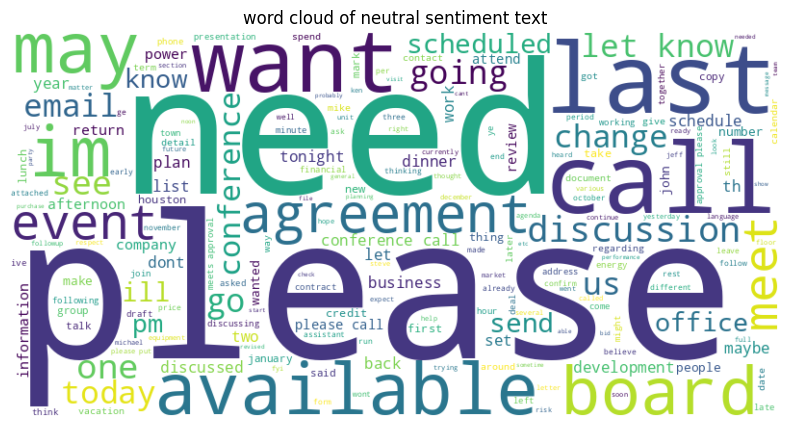

In [73]:
email_data_neu['preprocessed_text'] = email_data_neu['email_body'].apply(preprocess_text)

# Combine all preprocessed text into a single string
neu_text = " ".join(email_data_neu['preprocessed_text'])

# Generate the Word Cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate(neu_text)

# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("word cloud of neutral sentiment text")
plt.show()

<ipython-input-74-72c4016f37ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  email_data_formal['preprocessed_text'] = email_data_formal['email_body'].apply(preprocess_text)


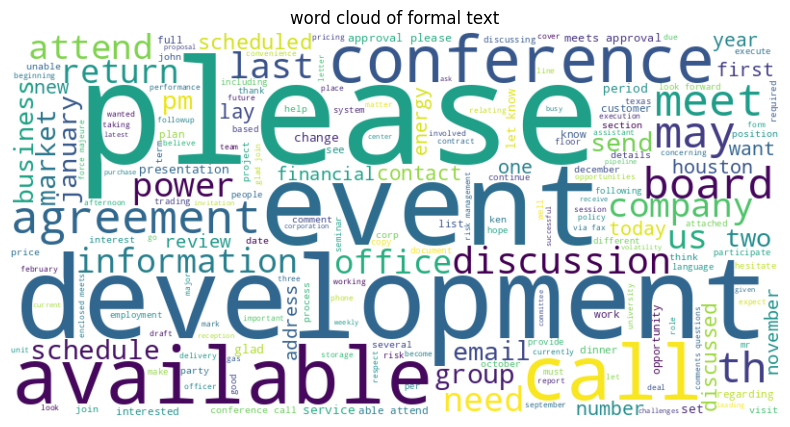

In [74]:
email_data_formal['preprocessed_text'] = email_data_formal['email_body'].apply(preprocess_text)

# Combine all preprocessed text into a single string
formal_text = " ".join(email_data_formal['preprocessed_text'])

# Generate the Word Cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate(formal_text)

# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("word cloud of formal text")
plt.show()

<ipython-input-75-217687a9ce23>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  email_data_informal['preprocessed_text'] = email_data_informal['email_body'].apply(preprocess_text)


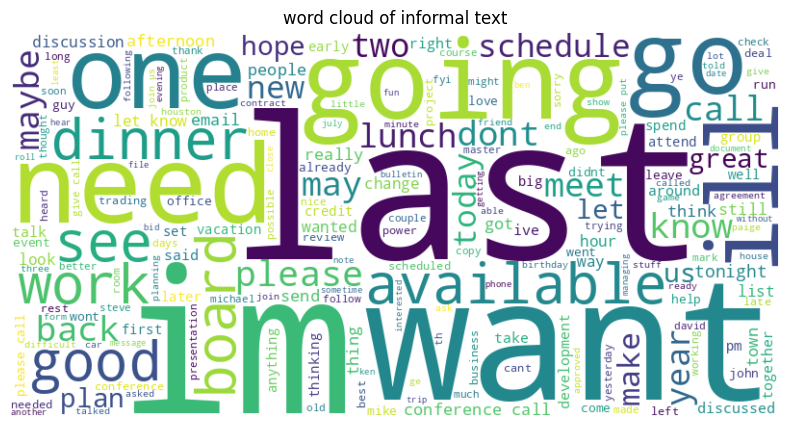

In [75]:
email_data_informal['preprocessed_text'] = email_data_informal['email_body'].apply(preprocess_text)

# Combine all preprocessed text into a single string
informal_text = " ".join(email_data_informal['preprocessed_text'])

# Generate the Word Cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate(informal_text)

# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("word cloud of informal text")
plt.show()